In [1]:
import pandas as pd

vivit_metrics = pd.read_csv("vivit_validation_metrics_all_runs.csv")

precision_metrics = vivit_metrics[vivit_metrics["Metric"] == "Precision"]
recall_metrics = vivit_metrics[vivit_metrics["Metric"] == "Recall"]
accuracy_metrics = vivit_metrics[vivit_metrics["Metric"] == "Accuracy"]

In [2]:
from scipy.stats import shapiro, levene
import numpy as np


def interpret_pvalue(pvalue: float, threshold: float = 0.05) -> str:
    """Interpret p-value against significance threshold"""
    return "PASSED" if pvalue > threshold else "FAILED"


def check_normality(metric_name: str, values: np.ndarray) -> None:
    """Test and interpret normality for a given metric"""
    statistic, pvalue = shapiro(values)
    result = interpret_pvalue(pvalue)
    print(f"{metric_name:10} {result:8} (p={pvalue:.4f})")
    if result == "FAILED":
        print(f"          WARNING: {metric_name} is not normally distributed!")


def check_equal_variances(
    accuracy: np.ndarray,
    recall: np.ndarray,
    precision: np.ndarray,
) -> None:
    """Test and interpret equality of variances across metrics"""
    statistic, pvalue = levene(accuracy, recall, precision)
    result = interpret_pvalue(pvalue)
    print(f"\nEqual Variances Test: {result} (p={pvalue:.4f})")
    if result == "FAILED":
        print("WARNING: Metrics have significantly different variances!")


accuracy_values = accuracy_metrics["Value"]
recall_values = recall_metrics["Value"]
precision_values = precision_metrics["Value"]

print("\nNormality Tests (Shapiro-Wilk):")
print("-" * 40)
check_normality("Accuracy", accuracy_values)
check_normality("Recall", recall_values)
check_normality("Precision", precision_values)

print("\nEquality of Variance Tests (Levene):")
print("-" * 40)
# todo: here we should check against the values of convnext,
# for now I'm leaving this as it is to test it is working
check_equal_variances(accuracy_values, recall_values, precision_values)


Normality Tests (Shapiro-Wilk):
----------------------------------------
Accuracy   PASSED   (p=0.5759)
Recall     PASSED   (p=0.1897)
Precision  PASSED   (p=0.6015)

Equality of Variance Tests (Levene):
----------------------------------------

Equal Variances Test: PASSED (p=0.7879)


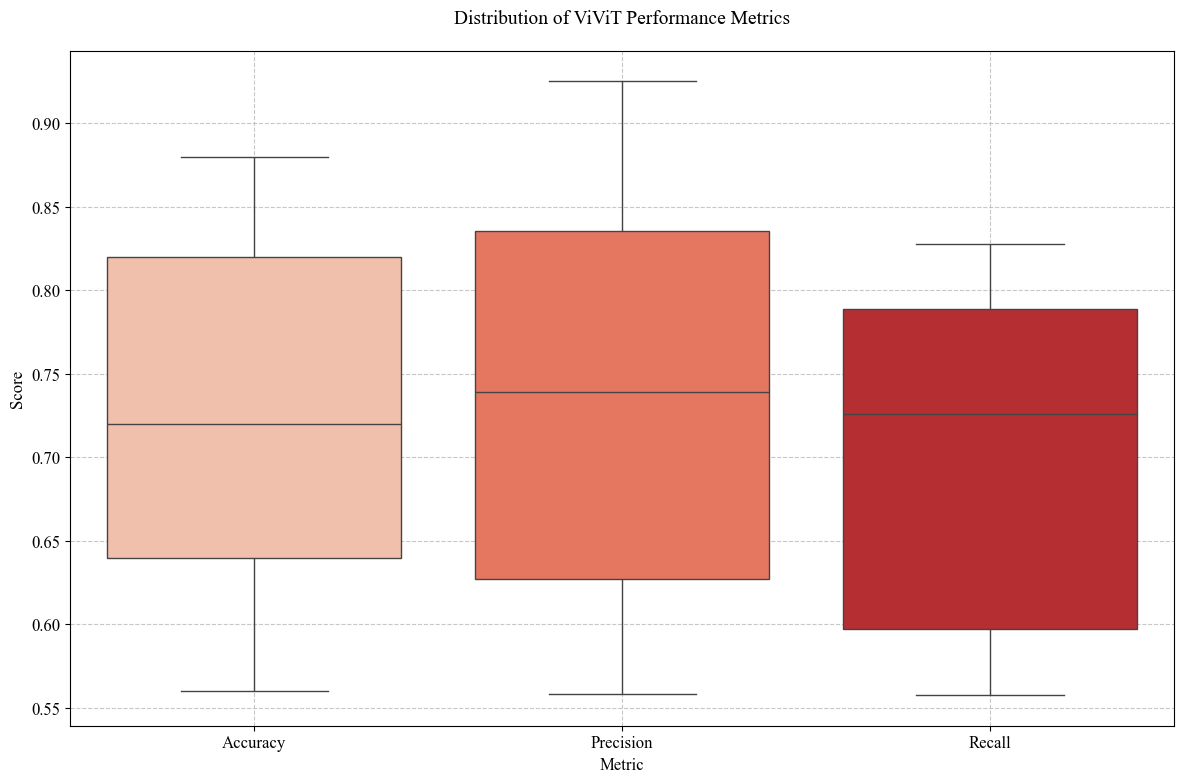

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


def create_metrics_boxplot(metrics: pd.DataFrame, name: str) -> None:
    """Create a box plot comparing accuracy, precision and recall"""
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 12

    plt.figure(figsize=(12, 8))

    colors = sns.color_palette("Reds", n_colors=3)

    sns.boxplot(
        x="Metric",
        y="Value",
        hue="Metric",
        data=metrics,
        palette=colors,
        legend=False,
    )

    plt.title(f"Distribution of {name} Performance Metrics", pad=20, fontsize=14)
    plt.xlabel("Metric", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()


# Create and display the plot
create_metrics_boxplot(vivit_metrics, name="ViViT")

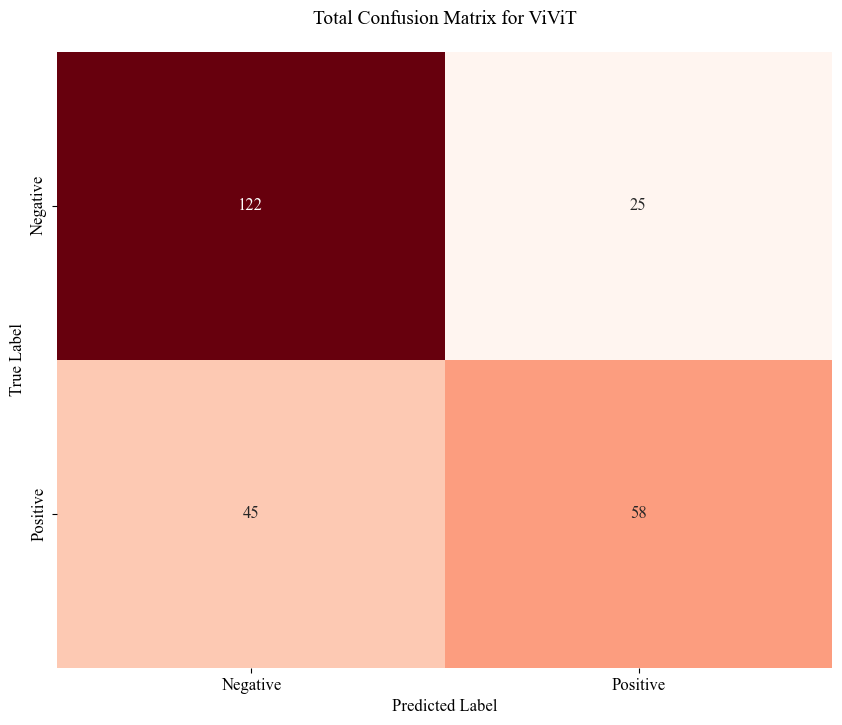

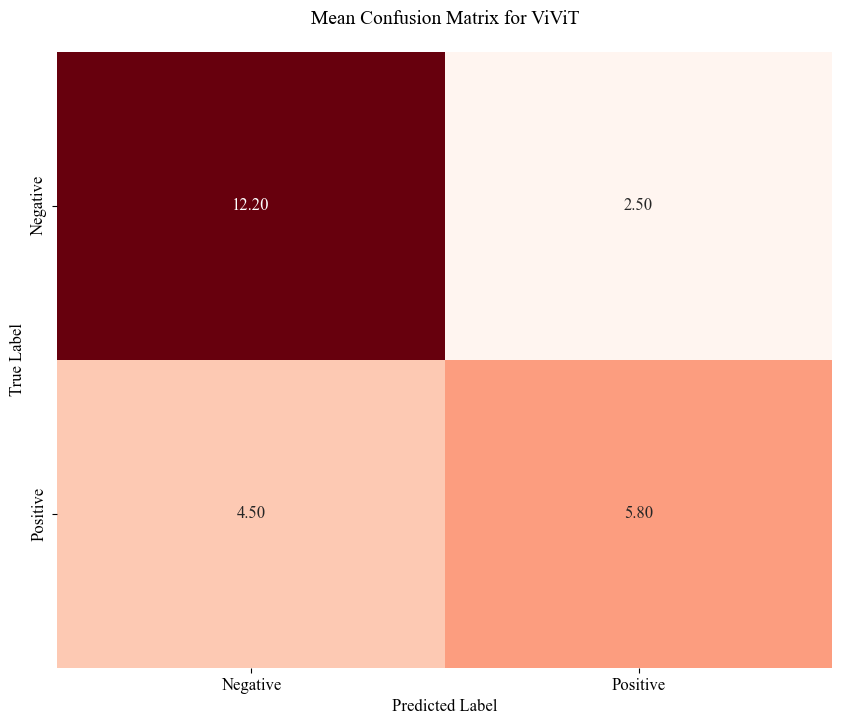

,Negative,Positive
Negative,122,25
Positive,45,58


In [4]:
def load_confusion_matrices(num_runs: int = 10) -> pd.DataFrame:
    """Load and sum all confusion matrices from CSV files"""
    base_path = "confusion_matrix_run_"
    cm = pd.read_csv(f"{base_path}0.csv")
    for i in range(1, num_runs):
        cm_path = f"{base_path}{i}.csv"
        cm = cm.add(pd.read_csv(cm_path), fill_value=0)

    return cm


def load_confusion_matrices_separated(num_runs: int = 10) -> pd.DataFrame:
    """Load confusion matrices from CSVs and combine them column-wise"""
    base_path = "confusion_matrix_run_"

    combined_data = []

    for i in range(num_runs):
        cm_path = f"{base_path}{i}.csv"
        cm = pd.read_csv(cm_path, header=None)
        combined_data.append(
            [cm.iloc[1, 0], cm.iloc[1, 1], cm.iloc[2, 0], cm.iloc[2, 1]]
        )

    combined_df = pd.DataFrame(
        combined_data, columns=["[0, 0]", "[0, 1]", "[1, 0]", "[1, 1]"]
    )

    return combined_df


def style_confusion_matrix() -> None:
    """Apply consistent styling to confusion matrix plots"""
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 12
    plt.figure(figsize=(10, 8))


def plot_confusion_matrix(cm: pd.DataFrame, title: str, fmt: str = "d") -> None:
    """Create and display a confusion matrix heatmap"""
    style_confusion_matrix()
    cm.columns = ["Negative", "Positive"]
    cm.index = ["Negative", "Positive"]

    sns.heatmap(cm, annot=True, fmt=fmt, cmap="Reds", cbar=False)
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.show()


total_cm = load_confusion_matrices()
plot_confusion_matrix(total_cm, title="Total Confusion Matrix for ViViT")

mean_cm = total_cm / 10
plot_confusion_matrix(mean_cm, title="Mean Confusion Matrix for ViViT", fmt=".2f")

total_cm

<Figure size 1000x800 with 0 Axes>

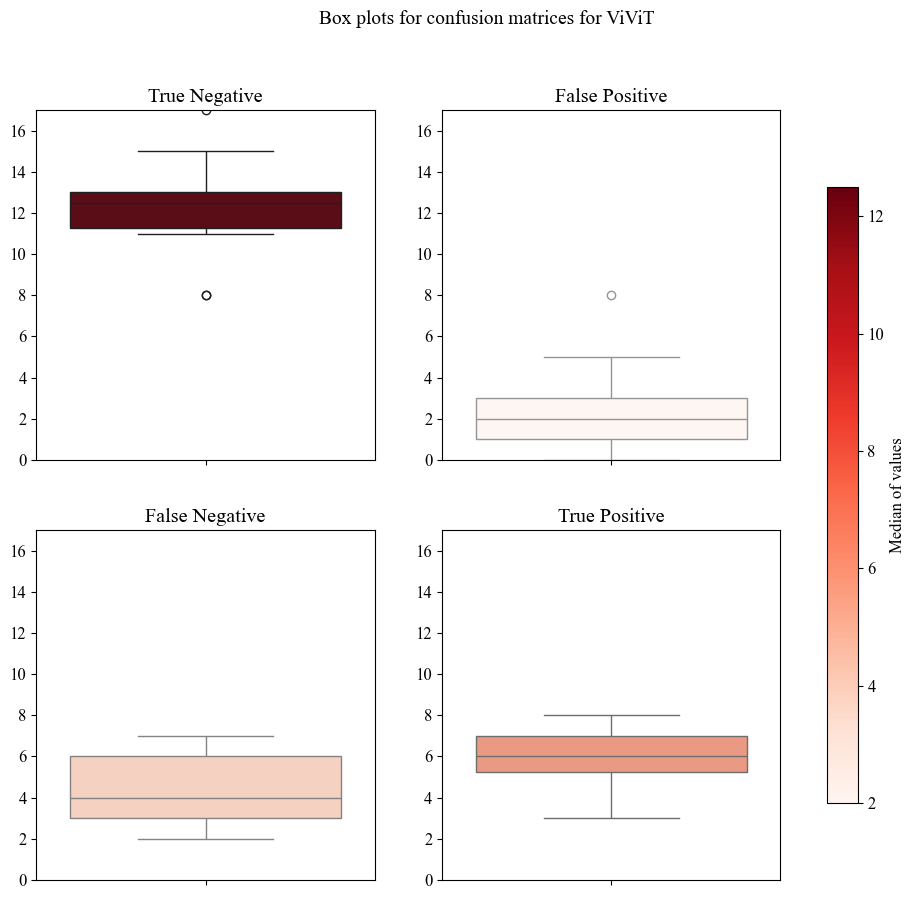

In [5]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import statistics


def map_colors(data: list) -> ScalarMappable:
    """Map data values to colors for a heatmap"""
    norm = Normalize(vmin=min(data), vmax=max(data))
    cmap = plt.cm.Reds
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    return sm


def plot_confusion_matrix_boxplots(
    cm: pd.DataFrame, title: str, fmt: str = "d"
) -> None:
    """Create and display a confusion matrix with heat box plots"""
    style_confusion_matrix()
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    data_sets = [
        cm.loc[:, "[0, 0]"].values,
        cm.loc[:, "[0, 1]"].values,
        cm.loc[:, "[1, 0]"].values,
        cm.loc[:, "[1, 1]"].values,
    ]

    titles = [
        "True Negative",
        "False Positive",
        "False Negative",
        "True Positive",
    ]

    medians = [np.median(data) for data in data_sets]
    sm = map_colors(medians)

    axes = axs.flatten()
    global_min = min(min(data) for data in data_sets)
    global_max = max(max(data) for data in data_sets)

    for i, ax in enumerate(axes):
        color = sm.to_rgba(medians[i])

        sns.boxplot(data=data_sets[i], ax=ax, color=color)
        ax.set_title(f"{titles[i]}")

        ax.set_ylim(global_min, global_max)

    fig.colorbar(
        sm, ax=axs, orientation="vertical", shrink=0.8, label="Median of values"
    )
    fig.suptitle(title, fontsize=14)

    plt.show()


separated_cm = load_confusion_matrices_separated()
plot_confusion_matrix_boxplots(
    separated_cm, title="Box plots for confusion matrices for ViViT"
)